# Optimize the Beale Function using Stochastic Gradient Descent

### Gradient Descent

$$ \mathbf{w}' = \mathbf{w} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{w}} $$

* Another notation

$$ \mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta_{t} \frac{\partial \mathcal{L}}{\partial \mathbf{w}_{t}} $$


####  Learning rate schedule
* Learning rate $\eta_{t}$ can be changed at time $t$

* Many learning rate schedule algorithms
  * [tf.train.exponential_decay](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)
  * [tf.train.polynomial_decay](https://www.tensorflow.org/api_docs/python/tf/train/polynomial_decay)
  * [tf.train.inverse_time_decay](https://www.tensorflow.org/api_docs/python/tf/train/inverse_time_decay)
  * and so on

### Description

* This code is just a refactoring code from `04.1.sgd.ipynb`
* Converted each variables `x` and `y` as a one `numpy.array` type vector which variable name is `vars` for ease of implementation.
* Likewise, converted each gradient variables `dx` and `dy` as a one `numpy.array` which name is `grads`.

## Import

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

## Beale function

$$ f(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x +xy^{3})^{2}$$

* analytic solution (global minima)
  * $(x, y) = (3, 0.5)$

In [2]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [3]:
def gradients(x, y):
  """Gradient of Beale function.

  Args:
    x: x-dimension of inputs
    y: y-dimension of inputs

  Returns:
    grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
      dx: gradient of Beale function with respect to x-dimension of inputs
      dy: gradient of Beale function with respect to y-dimension of inputs
  """
  dx = 2. * ( (1.5 - x + x * y) * (y - 1) + \
                (2.25 - x + x * y**2) * (y**2 - 1) + \
                (2.625 - x + x * y**3) * (y**3 - 1) )
  dy = 2. * ( (1.5 - x + x * y) * x + \
              (2.25 - x + x * y**2) * 2. * x * y + \
              (2.625 - x + x * y**3) * 3. * x * y**2 )
  grads = np.array([dx, dy])
  return grads

In [4]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [3.  0.5]
minima (2x1 column vector shape):
[[3. ]
 [0.5]]


In [5]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

### 3D plot with minima

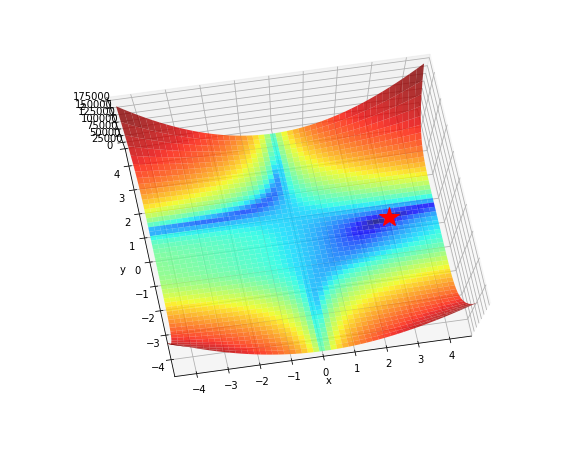

In [6]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

ax.plot_surface(x_mesh, y_mesh, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=20)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

### Contour plot with minima

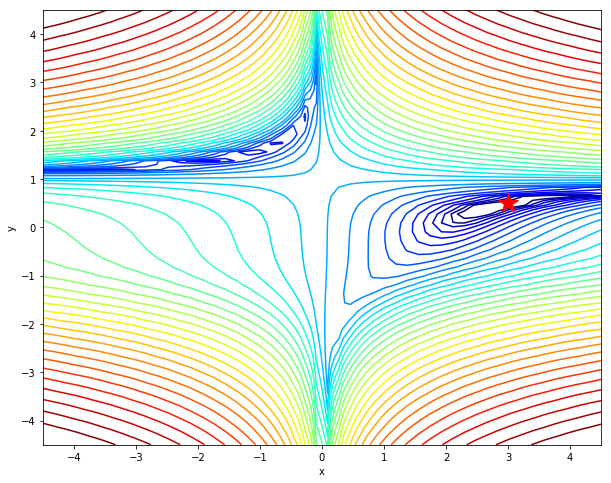

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()

## Build a Optimizer

In [8]:
class GradientDescentOptimizer():
  def __init__(self, function, gradients, x_init=None, y_init=None, learning_rate=0.01):
    self.f = function
    self.g = gradients
    scale = 3.0
    self.vars = np.zeros([2])
    if x_init is not None:
      self.vars[0] = x_init
    else:
      self.vars[0] = np.random.uniform(low=-scale, high=scale)
    if y_init is not None:
      self.vars[1] = y_init
    else:
      self.vars[1] = np.random.uniform(low=-scale, high=scale)
    print("x_init: {:.3f}".format(self.vars[0]))
    print("y_init: {:.3f}".format(self.vars[1]))
    
    self.lr = learning_rate
    
    # for accumulation of loss and path (w, b)
    self.z_history = []
    self.x_history = []
    self.y_history = []
  
  
  def func(self, variables):
    """Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      z: Beale function value at (x, y)
    """
    x, y = variables
    z = self.f(x, y)
    return z
  
  def gradients(self, variables):
    """Gradient of Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
        dx: gradient of Beale function with respect to x-dimension of inputs
        dy: gradient of Beale function with respect to y-dimension of inputs
    """
    x, y = variables
    grads = self.g(x, y)
    return grads
  
  def weights_update(self, grads):
    """Weights update using Gradient descent.
    
      w' = w - lr * dL/dw
    """
    self.vars = self.vars - self.lr * grads
    
  def history_update(self, z, x, y):
    """Accumulate all interesting variables
    """
    self.z_history.append(z)
    self.x_history.append(x)
    self.y_history.append(y)
    
    
  def train(self, max_steps):
    pre_z = 0.0
    print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, self.func(self.vars), self.x, self.y))
    
    file = open('sgd.txt', 'w')
    file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
    
    for step in range(max_steps):
      self.z = self.func(self.vars)
      self.history_update(self.z, self.x, self.y)

      self.grads = self.gradients(self.vars)
      self.weights_update(self.grads)
      file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
      
      if (step+1) % 100 == 0:
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y, self.dx, self.dy))
        
      if np.abs(pre_z - self.z) < 1e-6:
        print("Enough convergence")
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y))
        self.z = self.func(self.vars)
        self.history_update(self.z, self.x, self.y)
        break
        
      pre_z = self.z
    file.close()

    self.x_history = np.array(self.x_history)
    self.y_history = np.array(self.y_history)
    self.path = np.concatenate((np.expand_dims(self.x_history, 1), np.expand_dims(self.y_history, 1)), axis=1).T
    
    
  @property
  def x(self):
    return self.vars[0]
  
  @property
  def y(self):
    return self.vars[1]
  
  @property
  def dx(self):
    return self.grads[0]
  
  @property
  def dy(self):
    return self.grads[1]

### Create a `GradientDescentOptimizer()` class

In [9]:
opt = GradientDescentOptimizer(f, gradients, x_init=0.7, y_init=1.4, learning_rate=0.01)
#opt = GradientDescentOptimizer(f, x_init=-2.5, y_init=-2.5, learning_rate=0.0001) # local minimum

x_init: 0.700
y_init: 1.400


### Training

In [10]:
%time
opt.train(1000)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs
steps: 0  z: 26.496662  x: 0.70000  y: 1.40000
steps: 100  z: 0.096636  x: 2.44472  y: 0.32327  dx: -0.41345  dy: -0.16275
steps: 200  z: 0.021728  x: 2.69244  y: 0.41208  dx: -0.15311  dy: -0.04974
steps: 300  z: 0.007734  x: 2.80373  y: 0.44659  dx: -0.08138  dy: -0.02408
steps: 400  z: 0.003281  x: 2.86728  y: 0.46488  dx: -0.04962  dy: -0.01390
steps: 500  z: 0.001523  x: 2.90744  y: 0.47594  dx: -0.03243  dy: -0.00878
steps: 600  z: 0.000746  x: 2.93424  y: 0.48311  dx: -0.02207  dy: -0.00583
steps: 700  z: 0.000377  x: 2.95272  y: 0.48795  dx: -0.01541  dy: -0.00401
steps: 800  z: 0.000195  x: 2.96573  y: 0.49132  dx: -0.01094  dy: -0.00281
Enough convergence
steps: 838  z: 0.000153  x: 2.96963  y: 0.49232


### Results

In [11]:
print("Global minima")
print("x*: {:.2f}  y*: {:.2f}".format(minima[0], minima[1]))
print("Solution using the gradient descent")
print("x: {:.4f}  y: {:.4f}".format(opt.x, opt.y))

Global minima
x*: 3.00  y*: 0.50
Solution using the gradient descent
x: 2.9696  y: 0.4923


### Beale function plot

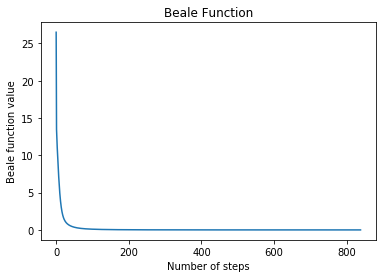

In [12]:
#Plot the Beale function
plt.title('Beale Function')
plt.xlabel('Number of steps')
plt.ylabel('Beale function value')
plt.plot(opt.z_history)
plt.show()

### Plot setting

In [13]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

### 3D plot with learning path

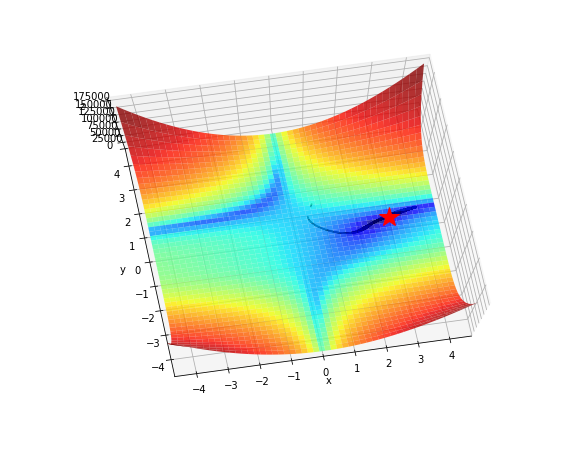

In [14]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path = opt.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

ax.plot_surface(x_mesh, y_mesh, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], opt.func([*path[::,:-1]]),
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          opt.func([*path[::,1:]]) - opt.func([*path[::,:-1]]),
          color='k', length=1, normalize=True)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

### Contour plot with learning path

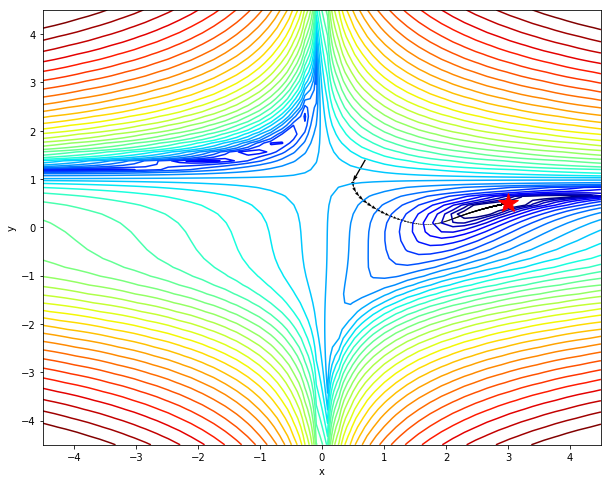

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()